# **SRM :** Semantic-Based Recommendation Model

##Environment Setup

In [1]:
# Mounting the google Drive For accessing the data else if you are running locally you can ignore it
from google.colab import drive
drive.mount('/content/drive')

# Installing packages for colab
!pip install umap
!pip install hdbscan
!pip install bertopic

# Importing the requied packages
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from wordcloud import WordCloud
from textblob import TextBlob
import nltk
import umap
import hdbscan
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from bertopic.representation import KeyBERTInspired
from bertopic import BERTopic
from bertopic.vectorizers import ClassTfidfTransformer
from bertopic.representation import MaximalMarginalRelevance, PartOfSpeech
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import CountVectorizer
from sentence_transformers import SentenceTransformer, util
import tensorflow as tf
import tensorflow_hub as hub
from transformers.pipelines import pipeline
import string
import re
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud, STOPWORDS
import torch
import json
from sklearn.cluster import KMeans

device = 'cuda' if torch.cuda.is_available() else 'cpu'

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

Mounted at /content/drive
  Preparing metadata (setup.py) ... done
  Created wheel for umap: filename=umap-0.1.1-py3-none-any.whl size=3542 sha256=6694733ba9d8a84a38b1eedfe5260074a3ac9d2507cfd378008d8bb9357c8a59
  Stored in directory: /root/.cache/pip/wheels/15/f1/28/53dcf7a309118ed35d810a5f9cb995217800f3f269ab5771cb
Successfully built umap
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 64.8 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached 

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

## Data Ingestion

In [4]:
wrk_dir = './drive/MyDrive/CS 7643 Project/'
# If running for the first time then run this cell else skip it
df = pd.read_excel(wrk_dir + 'Data/Reviews.xlsx')
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [5]:
# If running for the first time and want to see step by step then set the following to True
# else can load from the loaded data to save time

running_first = False

## Data Proprocessing:
*   We cleaned our reviews data by removing all non alphabetic characters and stop words as they would not add any value to the semantic representation of the review.
*   Since we were doing topic modeling hence we made sure that sentences with just one words are nouns this ensured more meaningful topics.
*   We performed stemming for text normalization and reduced all the words to their root as this would help us consolidate the words with same base and enhance the topic modeling.
*  We also removed the empty records.



In [6]:
if (running_first):
  porter_stemmer = PorterStemmer()
  st_words = stopwords.words('english')
  st_words.append('br')
  def preprocess_sent(sentence):
      keep_tags = ['NN', 'NNS', 'NNPS']
      stop_words = set(st_words)
      word_tokens = word_tokenize(sentence)
      word_tokens = [w.lower() for w in word_tokens if w.lower() not in stop_words]
      word_tokens = [i for i in word_tokens if i not in string.punctuation]
      word_tokens = [token for token in word_tokens if token.isalpha()]
      word_tokens = [porter_stemmer.stem(word) for word in word_tokens]
      if len(word_tokens)==1:
          tags = nltk.pos_tag(word_tokens, lang='eng')
          if tags[0][1] in keep_tags:
              return word_tokens[0]
          else:
              return ''
      else:
          return ' '.join(word_tokens)
  preprocessed_data = df.copy()
  preprocessed_data['Review'] = preprocessed_data['Text'].apply(preprocess_sent)
  preprocessed_data = preprocessed_data[preprocessed_data['Review']!=''].reset_index(drop=True)
  # Saving the preprocessed data
  preprocessed_data.to_excel(wrk_dir + "Data/preprocessed_data_rr.xlsx")
else:
  preprocessed_data = pd.read_excel(wrk_dir + '/Data/preprocessed_data_rr.xlsx', index_col=0)

# Checking the data
print('Total Records and Columns: ', preprocessed_data.shape)
print(preprocessed_data.head())



Total Records and Columns:  (568453, 11)
   Id   ProductId          UserId                      ProfileName  \
0   1  B001E4KFG0  A3SGXH7AUHU8GW                       delmartian   
1   2  B00813GRG4  A1D87F6ZCVE5NK                           dll pa   
2   3  B000LQOCH0   ABXLMWJIXXAIN  Natalia Corres "Natalia Corres"   
3   4  B000UA0QIQ  A395BORC6FGVXV                             Karl   
4   5  B006K2ZZ7K  A1UQRSCLF8GW1T    Michael D. Bigham "M. Wassir"   

   HelpfulnessNumerator  HelpfulnessDenominator  Score        Time  \
0                     1                       1      5  1303862400   
1                     0                       0      1  1346976000   
2                     1                       1      4  1219017600   
3                     3                       3      2  1307923200   
4                     0                       0      5  1350777600   

                 Summary                                               Text  \
0  Good Quality Dog Food  I have bough

## User & Product Historical Mapping

As to correctly identify a user and product in semantic space we needed all the interactions/records that included them hence to do this we concatenated all the reviews against a particular product and user. We would use this for subsequent steps as using all the iteractions for particular user or product we can correctly identify all the relevant topics/clusters for them.

In [7]:

if (running_first):
  user_mapping = preprocessed_data.groupby(['UserId']).agg({
      'Review': lambda x: ' '.join(x),
      'Score': 'mean'
  }).reset_index()

  product_mapping = preprocessed_data.groupby(['ProductId']).agg({
      'Review': lambda x: ' '.join(x),
      'Score': 'mean'
  }).reset_index()

  output_df = preprocessed_data.groupby(['UserId','ProductId']).agg({
      'Score': 'mean'
  }).reset_index()

  user_mapping.to_excel(wrk_dir + "Data/user_mapping_rr.xlsx")
  product_mapping.to_excel(wrk_dir + "Data/prod_mapping_rr.xlsx")
  output_df.to_excel(wrk_dir + "Data/output_mapping_rr.xlsx")
else:
  user_mapping = pd.read_excel(wrk_dir + "Data/user_mapping_rr.xlsx", index_col=0)
  product_mapping = pd.read_excel(wrk_dir + "Data/prod_mapping_rr.xlsx", index_col=0)
  output_df = pd.read_excel(wrk_dir + "Data/output_mapping_rr.xlsx", index_col=0)


print('total users: ', user_mapping.shape)
print('total products: ', product_mapping.shape)
print('total interactions: ', output_df.shape)
print(user_mapping.head())
print(product_mapping.head())
print(output_df.head())

total users:  (256058, 3)
total products:  (74258, 3)
total interactions:  (560803, 3)
               UserId                                             Review  \
0  #oc-R103C0QSV1DF5E  say littl apprehens buy product price like kee...   
1  #oc-R109MU5OBBZ59U  receiv free k cup sampl promot love least one ...   
2  #oc-R10LFEMQEW6QGZ  brooklyn bean roasteri blend great tast coffe ...   
3  #oc-R10LT57ZGIB140  shipment dog food quick howev open main box co...   
4  #oc-R10UA029WVWIUI  brooklyn french roast coffe one favorit aw oka...   

   Score  
0    5.0  
1    5.0  
2    5.0  
3    3.0  
4    1.0  
    ProductId                                             Review     Score
0     6641040  day person say chicken soup probabl go follow ...  4.351351
1  2734888454  dog love chicken product china wont buy anymor...  3.500000
2  2841233731  book easi read ingredi avail store unlik recip...  5.000000
3  7310172001  product health snack pup made beef liver puppi...  4.751445
4  7310172101  

## EDA

### WordCloud

To understand the raw data better we plot the word-cloud.

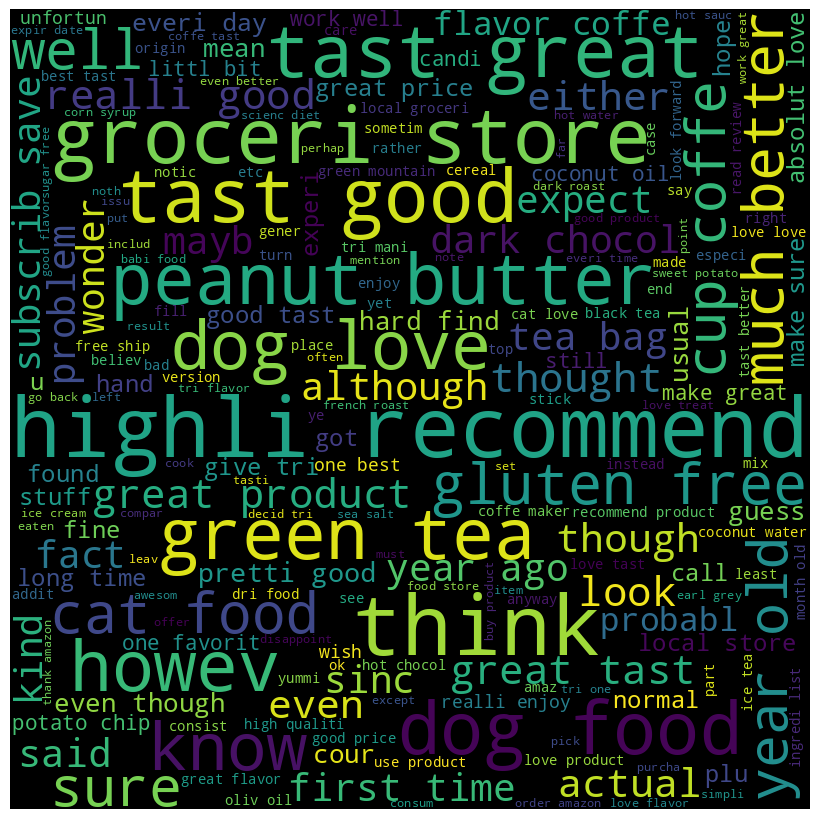

In [8]:
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='black',
                min_font_size = 10).generate(' '.join(preprocessed_data['Review']))

# plot the WordCloud image
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)

plt.show()

## Topic Modelling - **Users**

Utilizing the user mapping we will first find the main topics with respect to users and cluster all users according to these.

*Here we are converting the users reviews to embeddings space which can be used for topic modelling in subsequent steps. We have used **distilroberta-v1** but any other model can also be used.*

In [9]:
if (running_first):
  embedding_model_users = SentenceTransformer('all-distilroberta-v1', device = device)
  embeddings_users = embedding_model_users.encode(list(user_mapping['Review']),
                               convert_to_tensor=True,
                               show_progress_bar=True, device=device)
  np.save(wrk_dir + "Data/embeddings_users.npy",embeddings_users.cpu().numpy())
else:
  embedding_model_users = SentenceTransformer('all-distilroberta-v1', device = device)
  embeddings_users = np.load(wrk_dir + 'Data/embeddings_users.npy')
print('Sanity Check: ', np.linalg.norm(embeddings_users[1,:]))
print('Users Embeddings Shape: ', embeddings_users.shape)

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.3k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/653 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/328M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/333 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Sanity Check:  0.99999994
Users Embeddings Shape:  (256058, 768)


### Submodels for BerTopic
After we have converted our raw data into embeddings space hence now we can use them as inputs for the next steps which are as follow:
- Dimensionality Reduction
- Clustering
- Tokenization
- Weight of tokens in each topics to find the best tokens representing the particular topic
- Fine Tuning Topic Representation

In [10]:
def rescale(x, inplace=False):
    """ Rescale an embedding so optimization will not have convergence issues.
    """
    if not inplace:
        x = np.array(x, copy=True)

    x /= np.std(x[:, 0]) * 10000

    return x

if (running_first):
  pca_embeddings_users = rescale(PCA(n_components=10).fit_transform(embeddings_users.cpu()))
else:
  pca_embeddings_users = rescale(PCA(n_components=10).fit_transform(embeddings_users))

# Dimensionality Reduction Model
dr_model_users = umap.UMAP(n_neighbors=30,
                           n_components=10,
                           metric='cosine',
                           init=pca_embeddings_users,
                           low_memory=False,
                           verbose=True)

# Clustering Model
cluster_model_user = KMeans(n_clusters=12000)

# Vectorizer Model
vectorizer_model_user = CountVectorizer(stop_words="english", ngram_range=(1,2))

# cTF-IDF Model
ctfidf_model_user = ClassTfidfTransformer(reduce_frequent_words=True)

# Representation Model for fine Tuning
representation_model_user = MaximalMarginalRelevance(diversity=0.45)

### BerTopic - Users

In [11]:
### Model training
if (running_first):
  bt_model_user = BERTopic(language='english',
                          top_n_words=10,
                          n_gram_range=(1,2),
                          nr_topics=12000,
                          min_topic_size = 30,
                          umap_model=dr_model_users,
                          embedding_model=embedding_model_users,
                          hdbscan_model=cluster_model_user,
                          calculate_probabilities=True,
                          representation_model=representation_model_user,
                          ctfidf_model=ctfidf_model_user,
                          vectorizer_model=vectorizer_model_user,
                          verbose=True)
  topics_pos, prob_pos = bt_model_user.fit_transform(list(user_mapping['Review']),
                                                    embeddings=embeddings_users.cpu().numpy())
  ### Saving the model

  bt_model_user.save(wrk_dir + "models/user_model_v4",
                    serialization="pickle")
else:
  ### Load the saved Model
  bt_model_user = BERTopic.load(wrk_dir + "models/user_model_v4")



Sat Aug 24 19:02:05 2024 Building and compiling search function


### Users Model Diagnostics

In [12]:
# Here we first check the total topics and their representation size
print('Shape of Model Output: ', bt_model_user.topic_embeddings_.shape)

Shape of Model Output:  (12000, 768)


In [13]:
if (running_first):
  user_mapping['topics'] = bt_model_user.topics_
  user_mapping['new_topics'] = user_mapping['topics']
  user_mapping.to_excel(wrk_dir + "Data/user_grouped_v1_3_rr.xlsx")
else:
  user_mapping = pd.read_excel(wrk_dir + "Data/user_grouped_v1_3_rr.xlsx", index_col=0)


print('Total Users and All Columns: ', user_mapping.shape)
print(user_mapping.head())






Total Users and All Columns:  (256058, 5)
               UserId                                             Review  \
0  #oc-R103C0QSV1DF5E  say littl apprehens buy product price like kee...   
1  #oc-R109MU5OBBZ59U  receiv free k cup sampl promot love least one ...   
2  #oc-R10LFEMQEW6QGZ  brooklyn bean roasteri blend great tast coffe ...   
3  #oc-R10LT57ZGIB140  shipment dog food quick howev open main box co...   
4  #oc-R10UA029WVWIUI  brooklyn french roast coffe one favorit aw oka...   

   Score  topics  new_topics  
0    5.0    9976        9976  
1    5.0    3470        3470  
2    5.0   11357       11357  
3    3.0     332         332  
4    1.0    1763        1763  


### Visualizations

In [ ]:
bt_model_user.visualize_barchart(top_n_topics=10, title="User Topics")

In [14]:
if (running_first):
  clustered_user_matrix = bt_model_user.topic_embeddings_/np.linalg.norm(bt_model_user.topic_embeddings_, axis=1)[:,None]
  # Saving
  np.save(wrk_dir + "Data/clustered_user_matrix_v3_rr.npy",clustered_user_matrix)
else:
  clustered_user_matrix = np.load(wrk_dir + 'Data/clustered_user_matrix_v3_rr.npy')
print(clustered_user_matrix.shape)
print(np.linalg.norm(clustered_user_matrix[9,:]))
clustered_user_matrix

(12000, 768)
0.99999994


array([[-0.00790706, -0.02263815,  0.00556995, ...,  0.0022899 ,
        -0.07094039,  0.03327832],
       [ 0.00896807,  0.00190571, -0.01417999, ..., -0.01452486,
         0.04837868, -0.0043339 ],
       [ 0.00470503, -0.02796302,  0.01262874, ..., -0.02037818,
         0.00800878, -0.00792627],
       ...,
       [ 0.02001837,  0.0098327 , -0.02658404, ..., -0.02305756,
         0.02333278,  0.01389212],
       [-0.03678734, -0.01167148, -0.02303389, ...,  0.00262163,
        -0.02996078, -0.00782513],
       [-0.03947513, -0.00782237, -0.03452021, ..., -0.02384242,
         0.0281311 ,  0.00334571]], dtype=float32)

## Topic Modelling for Products

In [15]:
if (running_first):
  model_prod = SentenceTransformer('all-distilroberta-v1', device = device)
  embeddings_prod = model_prod.encode(list(product_mapping['Review']),
                             convert_to_tensor=True,
                             show_progress_bar=True, device=device)

  np.save(wrk_dir + "Data/embeddings_prod_rr.npy",embeddings_prod.cpu().numpy())
else:
  embeddings_prod = np.load(wrk_dir + 'Data/embeddings_prod_rr.npy')


print('Sanity Check: ', np.linalg.norm(embeddings_prod[1,:]))
print('Products Embeddings Shape: ', embeddings_prod.shape)

Sanity Check:  1.0
Products Embeddings Shape:  (74258, 768)


#### Submodels for BerTopic

In [16]:
# PCA embeddings for UMAP initialization and rescaling for convergence.
def rescale(x, inplace=False):
    """ Rescale an embedding so optimization will not have convergence issues.
    """
    if not inplace:
        x = np.array(x, copy=True)

    x /= np.std(x[:, 0]) * 10000

    return x
if (running_first):
  pca_embeddings_prod = rescale(PCA(n_components=7).fit_transform(embeddings_prod.cpu()))
else:
  pca_embeddings_prod = rescale(PCA(n_components=7).fit_transform(embeddings_prod))

# Dimensionality Reduction Model
dr_model_prod = umap.UMAP(n_neighbors=30,
                           n_components=7,
                           metric='cosine',
                           init=pca_embeddings_prod,
                           low_memory=False,
                           verbose=True)

# Clustering Model
cluster_model_prod = KMeans(n_clusters=10000)

# Vectorizer Model
vectorizer_model_prod = CountVectorizer(stop_words="english", ngram_range=(1,2))

# cTF-IDF Model
ctfidf_model_prod = ClassTfidfTransformer(reduce_frequent_words=True)

# Representation Model for fine Tuning
representation_model_prod = MaximalMarginalRelevance(diversity=0.35)

### BerTopic - Products

In [17]:
### Model training
if (running_first):
  bt_model_prod = BERTopic(language='english',
                          top_n_words=15,
                          n_gram_range=(1,2),
                          nr_topics=10000,
                          min_topic_size = 30,
                          umap_model=dr_model_prod,
                          embedding_model=model_prod,
                          hdbscan_model=cluster_model_prod,
                          calculate_probabilities=True,
                          representation_model=representation_model_prod,
                          ctfidf_model=ctfidf_model_prod,
                          vectorizer_model=vectorizer_model_prod,
                          verbose=True)
  # If running first time change to CPU and then to NUMPY else if loading embeddings then its already as numpy
  topics_prod, prob_prod = bt_model_prod.fit_transform(list(product_mapping['Review']),
                                                    embeddings=embeddings_prod.cpu().numpy())

  ### Saving the model

  bt_model_prod.save(wrk_dir + "models/prod_model_rr",
                    serialization="pickle")
else:
  ### Load the saved Model
  bt_model_prod = BERTopic.load(wrk_dir + "models/prod_model_rr")



Sat Aug 24 19:08:57 2024 Building and compiling search function


### Product Model Diagnostics

In [18]:
# Here we first check the total topics and their representation size
print('Shape of Product Model Output: ', bt_model_prod.topic_embeddings_.shape)

Shape of Product Model Output:  (10000, 768)


In [19]:
if (running_first):
  product_mapping['topics'] = bt_model_prod.topics_
  product_mapping['new_topics'] = product_mapping['topics']
  product_mapping.to_excel(wrk_dir + "Data/prod_grouped_v1_3_rr.xlsx")
else:
  product_mapping = pd.read_excel(wrk_dir + "Data/prod_grouped_v1_3_rr.xlsx", index_col=0)


print('Total Products and All Columns: ', product_mapping.shape)
print(product_mapping.head())

Total Products and All Columns:  (74258, 5)
    ProductId                                             Review     Score  \
0     6641040  day person say chicken soup probabl go follow ...  4.351351   
1  2734888454  dog love chicken product china wont buy anymor...  3.500000   
2  2841233731  book easi read ingredi avail store unlik recip...  5.000000   
3  7310172001  product health snack pup made beef liver puppi...  4.751445   
4  7310172101  product health snack pup made beef liver puppi...  4.751445   

   topics  new_topics  
0    1629        1629  
1     838         838  
2    4889        4889  
3    1583        1583  
4    1583        1583  


### Visualizations

In [20]:
bt_model_prod.visualize_barchart(top_n_topics=10, title="Product Topics")

### Product Topic Embeddings

In [21]:
if (running_first):
  clustered_prod_matrix = bt_model_prod.topic_embeddings_/np.linalg.norm(bt_model_prod.topic_embeddings_, axis=1)[:,None]
  # Saving
  np.save(wrk_dir + "Data/clustered_prod_matrix_v3_rr.npy",clustered_prod_matrix)
else:
  clustered_prod_matrix = np.load(wrk_dir + 'Data/clustered_prod_matrix_v3_rr.npy')
print(clustered_prod_matrix.shape)
print(np.linalg.norm(clustered_prod_matrix[12,:]))
clustered_prod_matrix

(10000, 768)
1.0


array([[-0.02009424,  0.0003715 , -0.00296866, ...,  0.01855413,
        -0.01248581, -0.01082853],
       [-0.00402643, -0.04025764,  0.018344  , ..., -0.01027845,
        -0.07447488,  0.02379827],
       [ 0.00456339,  0.03849461, -0.02789804, ..., -0.03276531,
        -0.00361512, -0.01322   ],
       ...,
       [-0.04249609,  0.00475391, -0.03315053, ...,  0.01164706,
         0.03710227,  0.01203275],
       [-0.00677119, -0.01970397,  0.02220533, ...,  0.00924693,
        -0.03072082,  0.00142749],
       [-0.01191271, -0.02978407,  0.00450402, ..., -0.01322836,
        -0.06950535,  0.02833311]], dtype=float32)

## User-Topic_embedding and Products-Topic_embedding product

In [22]:
if running_first:
  final_mat = np.dot(clustered_user_matrix, clustered_prod_matrix.T)
  np.save(wrk_dir + "Data/final_mat_v3_rr.npy",final_mat)
else:
  final_mat = np.load(wrk_dir + 'Data/final_mat_v3_rr.npy')
print('shape of Dot Product: ', final_mat.shape)

shape of Dot Product:  (12000, 10000)


## Topics Representation Evaluation Using Octis Framework

*We import some packages here again as there were some dependencies discrepancies just run the following cell if it asks for the restart ignore that teh following code should run*

We used the diversity metric from OCTIS framework which as the names suggests find the diversity score hence higher score is better meaning we had found more diverse topics in our data.

In [25]:
import locale
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"
locale.getpreferredencoding = getpreferredencoding

!pip install octis
import octis

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 170.6/170.6 kB 9.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 131.0/131.0 kB 13.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.7/30.7 MB 49.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.4/38.4 MB 39.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 14.9 MB/s eta 0:00:00
  Created wheel for libsvm: filename=libsvm-3.23.0.4-cp310-cp310-linux_x86_64.whl size=251407 sha256=5c124e822ba97dd148540b6ff35c2fb50c272e3623fc07840454615c40ff5545
  Stored in directory: /root/.cache/pip/wheels/79/c7/19/a8c85928f8e629654b8e1adb3c8091f0bb77344d0ee9954a85
Successfully built libsvm
  Attempting uninstall: scipy
    Found existing installation: scipy 1.13.1
    Uninstalling scipy-

In [29]:
topics_rep_u = bt_model_user.topic_representations_
topic_model_u = {}
topics_u = []
for tr in topics_rep_u.keys():
  words_p = [v[0] for v in topics_rep_u[tr]]
  topics_u.append(words_p)
topic_model_u['topics'] = topics_u

from octis.evaluation_metrics.diversity_metrics import TopicDiversity
diversity = TopicDiversity(topk=10)
print('Diversity score for User Topics : '+str(diversity.score(topic_model_u)))

Diversity score for User Topics : 0.9925666666666667


In [28]:
topics_rep_p = bt_model_prod.topic_representations_
topic_model_p = {}
topics_p = []
for tr in topics_rep_p.keys():
  words_p = [v[0] for v in topics_rep_p[tr]]
  topics_p.append(words_p)
topic_model_p['topics'] = topics_p

from octis.evaluation_metrics.diversity_metrics import TopicDiversity
diversity = TopicDiversity(topk=10)
print('Diversity score for Product Topics : '+str(diversity.score(topic_model_p)))

Diversity score for Product Topics : 0.96973
